# Diamond EP Grouping Exploration

Previously basic EDA and PCA were attempted. From these some insight into which features indicate success were identified. A few promising ones include **total (unique) observations and shelx n data**, **anomalous correlation**, **high resolution limit** (also low resolution limit and SHELXC resolution), **DIFF F** (and I), and **RPIM/RMEAS/RMERGE (DIFF) I**.

However, so far analysis has been done on the dataset as a whole, ignoring other metrics which might better separate sample/crystal/measurement types (e.g. **space group, wavelength, solvent content, resolution frames**, etc.)

The following analysis will try to group the data by these relevant categories, in order to extract more useful info to be used in predictive model building. We start by creating the data.

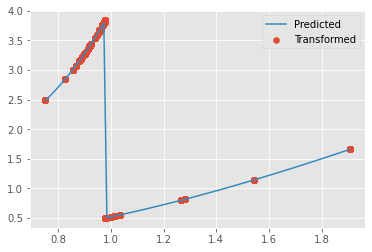

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.width", None)


def sql_to_df(db_file, *tb_names, search_query=None):
    '''
    function to connect to database and convert datum to pandas DataFrame
    use #TB_NAME# to refer to table name
    '''
    # make connection
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()

    for tb_name in tb_names:
        # query table
        cur.execute(search_query.replace("#TB_NAME#", tb_name))
        result = cur.fetchall()

        # fetch column names
        cur.execute(rf"PRAGMA table_info({tb_name})")
        cols = [info[1] for info in cur.fetchall()]

        # create DataFrame
        df = pd.DataFrame(result, columns=cols)
        df.set_index("id", inplace=True)
        df.name = tb_name

        yield df

        
def FDoublePrime(wavelength, threshold=0.9795):
    mask_low = wavelength >= threshold
    mask_high = wavelength < threshold
    result = wavelength.copy()

    a_low, b_low, c_low = 1.37919369, 0.2780599, 0.64429346
    a_high, b_high, c_high = 3.92791177, 1.34277082, -0.28303464

    result[mask_low] = (result[mask_low] - c_low) ** a_low + b_low
    result[mask_high] = (result[mask_high] - c_high) ** a_high + b_high
    
    return result
    

db_path = r"D:\Diamond\cesar_project.db"
tables = [r"SWEEP_STATS", r"EP_STATS"]  # , r"PDB_DATA", r"DATASET_INFO"]
query = r"SELECT * FROM #TB_NAME#"

sweep_full, ep_full = [i for i in sql_to_df(db_path, *tables, search_query=query)]  # old x, y

# cut to subset
sample_frac = 1
sweep, ep = sweep_full,ep_full#.sample(frac=sample_frac), ep_full.sample(frac=sample_frac)

x = sweep
# define label
y = ep["IS_SUCCESS"]
y.index = ep["DATASET_id"]
y = x["DATASET_id"].map(y)
y.name = "IS_SUCCESS"

# add ep stats to x
mapped = []
for col_name in ["SOLVENT_CONTENT", "NUMBER_SITES"]:
    ep_temp = ep.loc[:, col_name]
    ep_temp.index = ep["DATASET_id"]
    ep_temp = x["DATASET_id"].map(ep_temp)
    ep_temp.name = col_name

    mapped.append(ep_temp)

x = pd.concat([x] + mapped, axis=1)

# replace wavelength by f''
dummy_x = np.linspace(x["WAVELENGTH"].min(), x["WAVELENGTH"].max(), 100)
plt.style.use("ggplot")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(dummy_x, FDoublePrime(dummy_x), c=colors[1], label="Predicted")
plt.scatter(x["WAVELENGTH"], FDoublePrime(x["WAVELENGTH"].values), label="Transformed")

plt.legend()
plt.show()

x["WAVELENGTH"] = FDoublePrime(x["WAVELENGTH"].values)
x.rename(columns={"WAVELENGTH": "F''"}, inplace=True)

# limit to common datasets
valid_ids = set.intersection(set(x["DATASET_id"]), set(ep["DATASET_id"]))
a = x["DATASET_id"].isin(valid_ids)
x = x[x["DATASET_id"].isin(valid_ids)]
y = y[y.index.map(sweep["DATASET_id"]).isin(valid_ids)]

# filter out undetermined values
mask = y.isin([1, 0])
y = y[mask]
x = x[mask]
x.drop(columns="WAVE_NAME", inplace=True)

union = pd.concat([x.iloc[:, 1:], y], axis=1)

We first analyse the sorted distribution of the average success rate per space group using a bar plot (standard error of the mean was taken as the error).

Have 54 space groups with mean success rate of 0.2. Max of 0.43, min of 0.0.


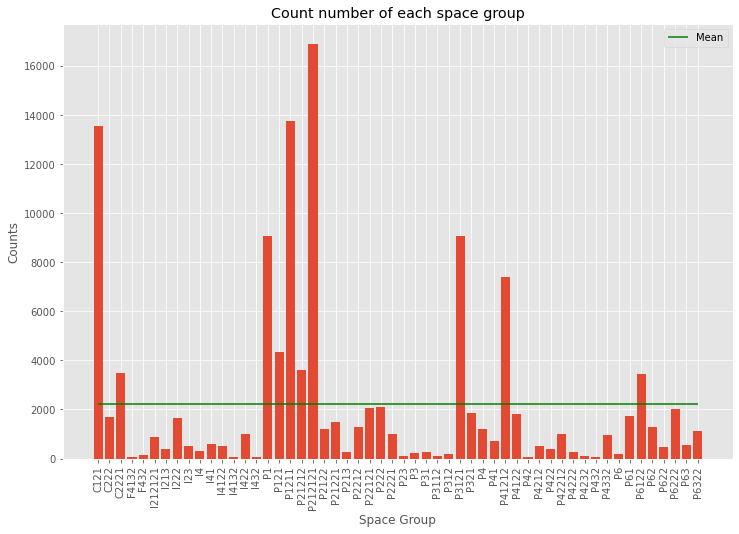

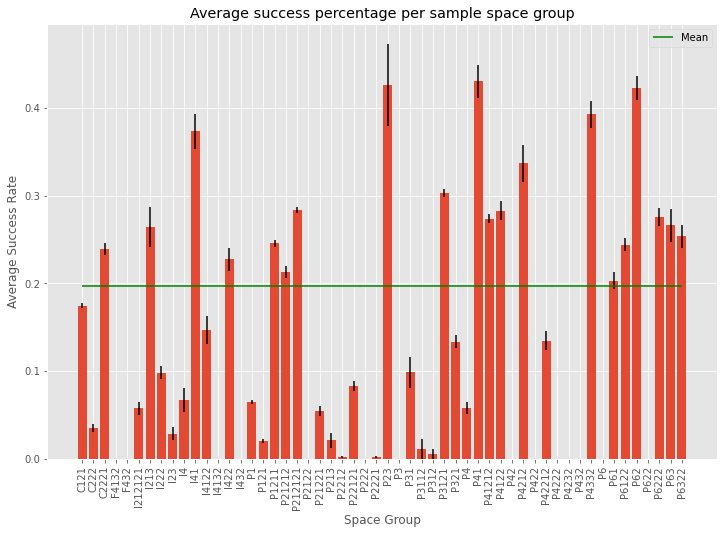

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

# separate spacegroups
spc_grp = x["SPACEGROUP"]

agg = union.groupby("SPACEGROUP").agg(["mean", "sem"])
agg_count = union.groupby("SPACEGROUP").count()
print(f"Have {spc_grp.drop_duplicates().size} space groups "
      f"with mean success rate of {round(y.mean(), 2)}. "
      f"Max of {round(agg['IS_SUCCESS', 'mean'].max(), 2)}, "
      f"min of {round(agg['IS_SUCCESS', 'mean'].min(), 2)}.")


def bar_plot(data, count=False):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.xticks(rotation=90)

    # bar plot & mean line
    if count:
        ax.bar(data.index, data["IS_SUCCESS"])
        ax.hlines(data.iloc[:, 0].mean(), 0, data.index.size - 1, colors="green", label="Mean")
        ax.legend()
        
        ax.set_title("Count number of each space group")
        ax.set_xlabel("Space Group")
        ax.set_ylabel("Counts")
    else:
        ax.bar(data.index, data["IS_SUCCESS", "mean"], yerr=data["IS_SUCCESS", "sem"])
        ax.hlines(y.mean(), 0, data.index.size - 1, colors="green", label="Mean")
        ax.legend()

        ax.set_title("Average success percentage per sample space group")
        ax.set_xlabel("Space Group")
        ax.set_ylabel("Average Success Rate")

    plt.show()


bar_plot(agg_count, count=True)
bar_plot(agg)

The success rate varies wildly, from 0% to 43%, but the errors remain relatively small. Although some space groups appear to be slightly grouped, or at least have similar success rates, the graph still appears to be **mostly random**.

To better analyse this, the data is **sorted**.

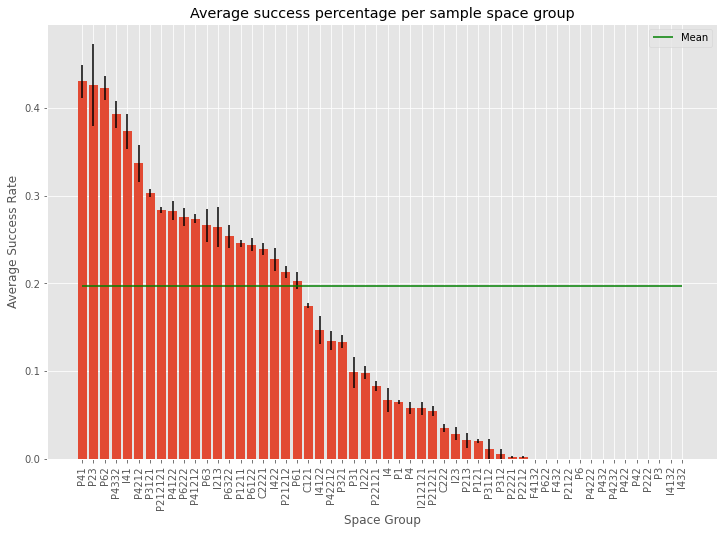

In [3]:
agg_sorted = agg.sort_values(("IS_SUCCESS", "mean"), ascending=False)

bar_plot(agg_sorted)

This plot shows several **"plateaus" of similar success rate**. If these plateaus can be sectioned into **groups**, then maybe each group has different feature importance (e.g. one group could depend highly on high resolution limit, while the other could depend more on the low resolution limit).

As such, grouping by average success rate into 3-7 groups was attempted using the simple unsupervised algorithm, *KMeans*.

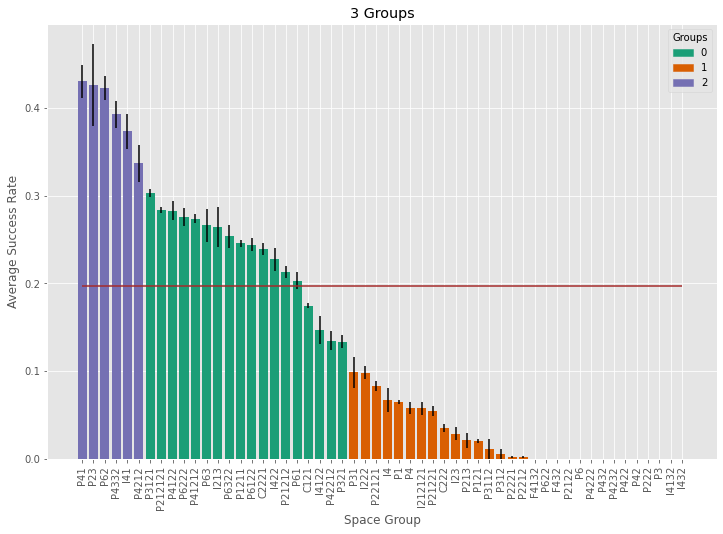

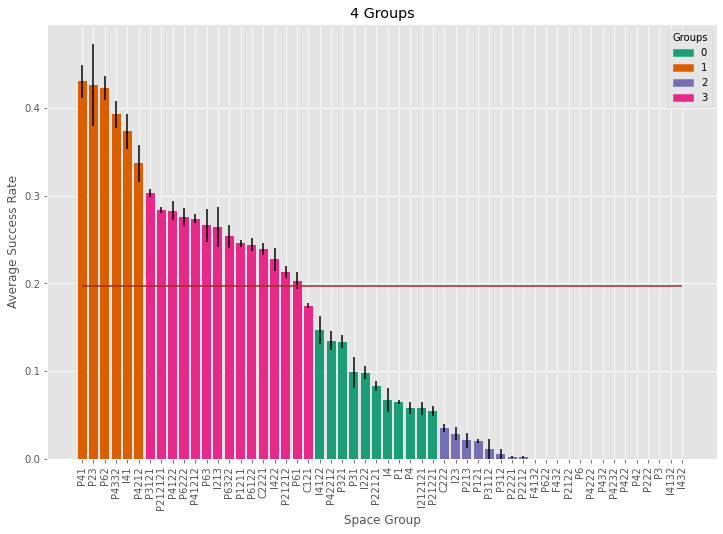

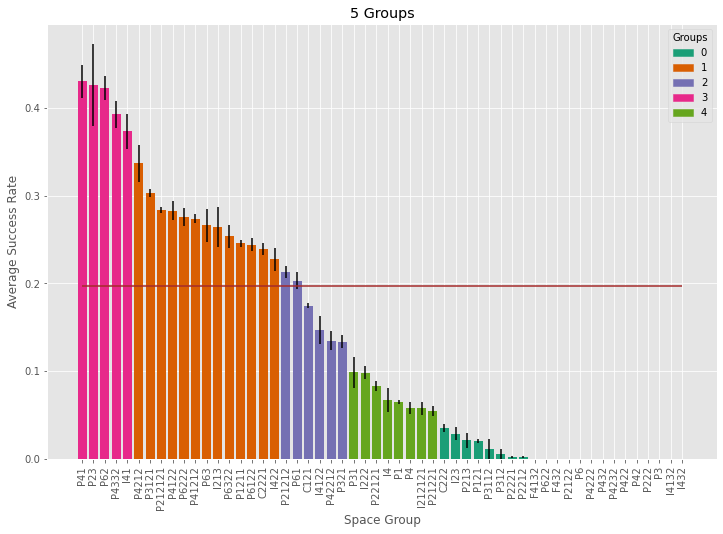

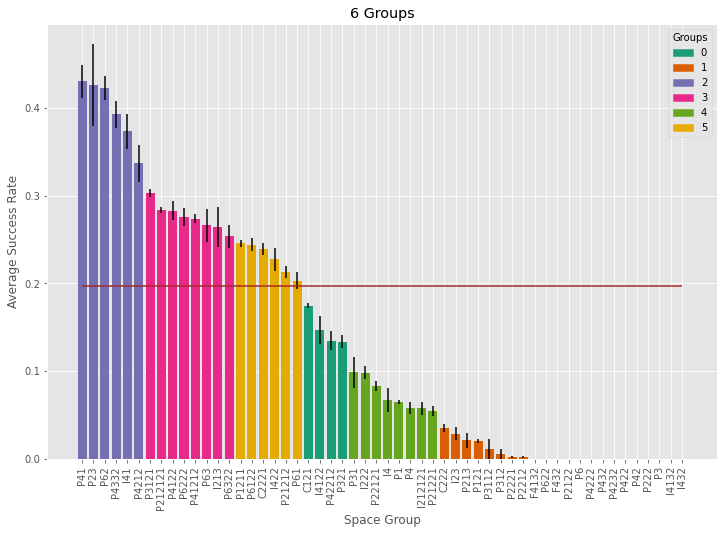

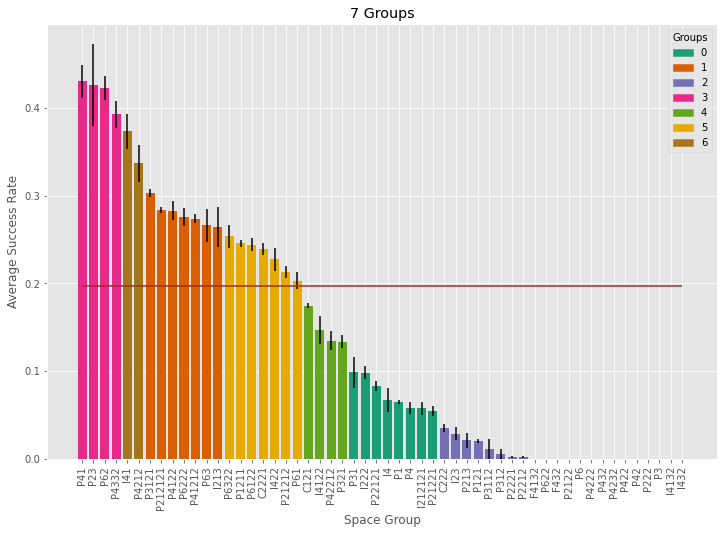

In [4]:
from sklearn.cluster import KMeans

def avg_success_bar_plot(n, show=True, sort_legend=True):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.xticks(rotation=90)

    # try ML grouping
    model = KMeans(n_clusters=n)
    pred = model.fit_predict(pd.DataFrame(agg_sorted["IS_SUCCESS", "mean"]))
    pred = pd.Series(pred, index=agg_sorted.index)

    # colormap
    cmap = mpl.cm.get_cmap("Dark2")
    c = pred.map(cmap)
    ax.bar(agg_sorted.index, agg_sorted["IS_SUCCESS", "mean"],
           yerr=agg_sorted["IS_SUCCESS", "sem"], color=c)
    ax.hlines(y.mean(), 0, agg_sorted.index.size - 1, colors="brown", label="Mean")

    # legend
    grps = pd.concat([pred.drop_duplicates(), c.drop_duplicates()], axis=1)
    if sort_legend:
        grps.columns = ["Group", "RGBA"]
        grps.sort_values("Group", inplace=True)
    patches = [mpl.patches.Patch(color=v, label=k) for k, v in grps.values]
    ax.legend(handles=patches, title="Groups")

    # text
    ax.set_title(f"{n} Groups")
    ax.set_xlabel("Space Group")
    ax.set_ylabel("Average Success Rate")

    if show:
        plt.show()
    
    return (fig, ax), (pred, c)

for n in [3, 4, 5, 6, 7]:
    avg_success_bar_plot(n)

The choice of better number of groups has a subjetive element to it. Personally, the **best-looking number of clusters is 4**, however *5 and 6 are also acceptable*. 3 is a bit too vague, but could still be used if wide grouping is required, but 7 is too "crowded" and not recommended.

Only less than half of the spacegroups have a higher than average success rate, meaning that the **distribution is not symmetric**.

Scatter plots colour coded using the 4 groups are then analysed to see if a higher/lower success rate has any relation to any feature.

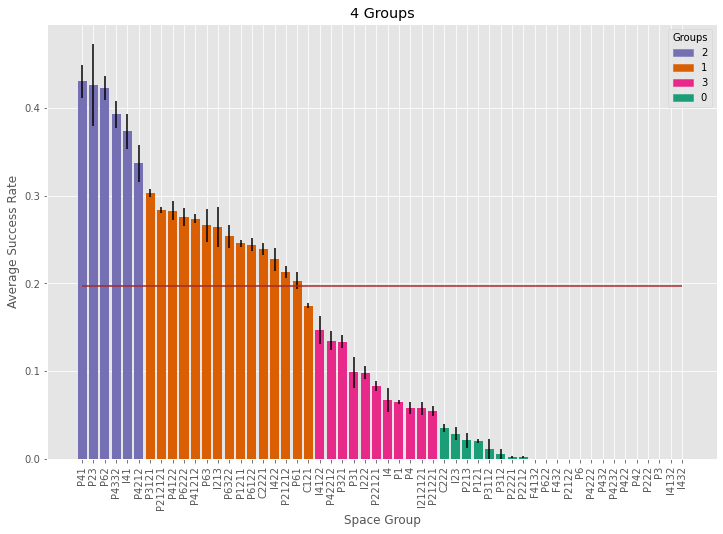

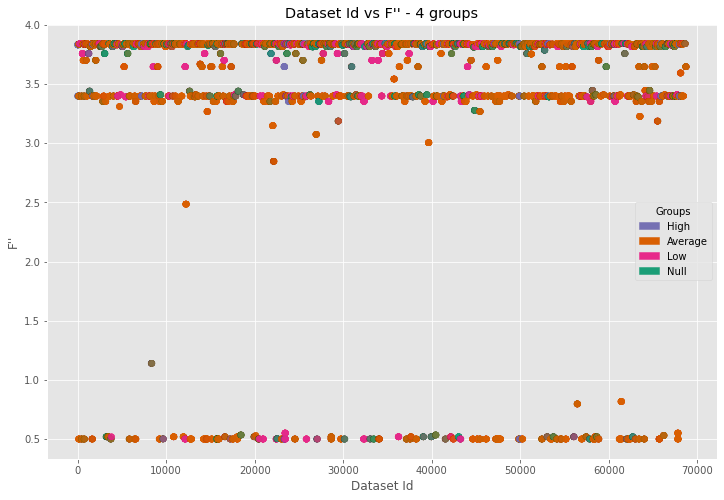

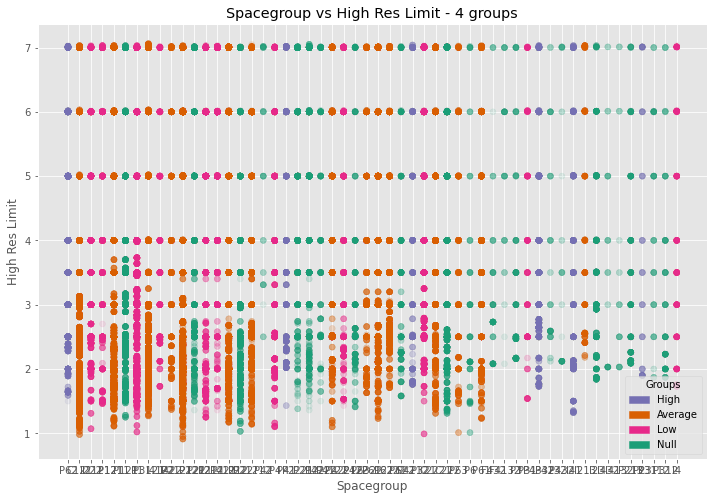

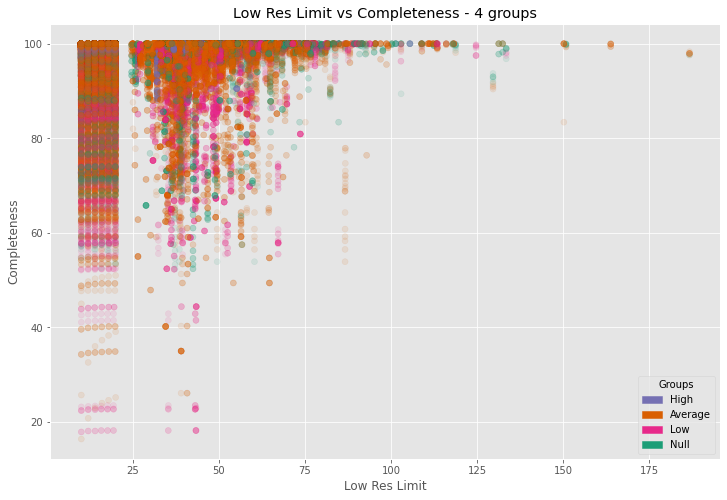

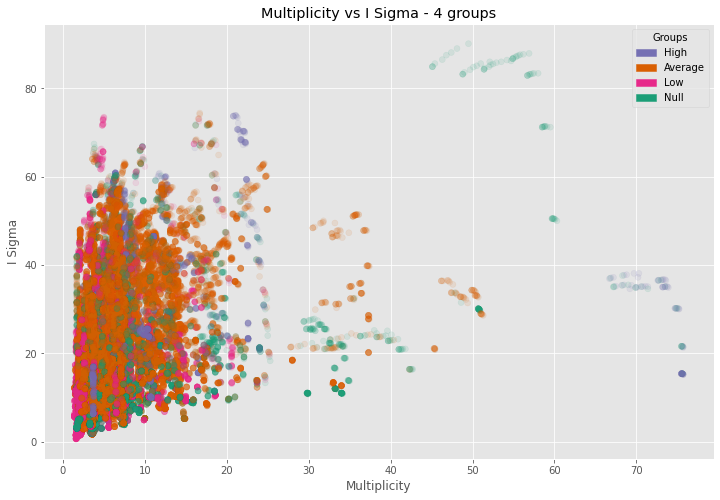

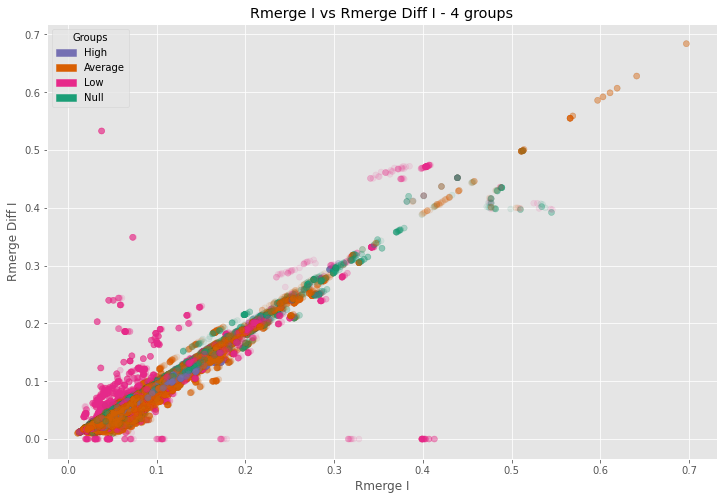

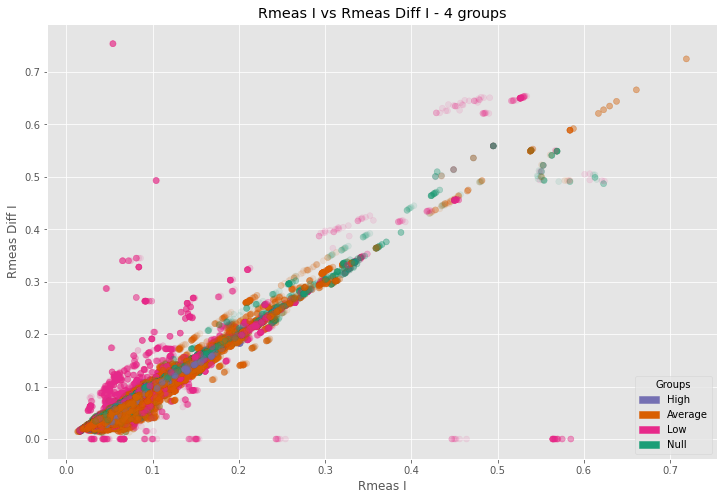

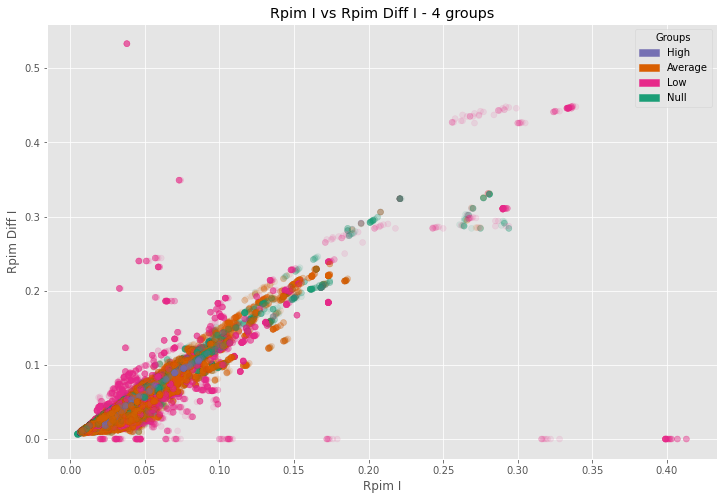

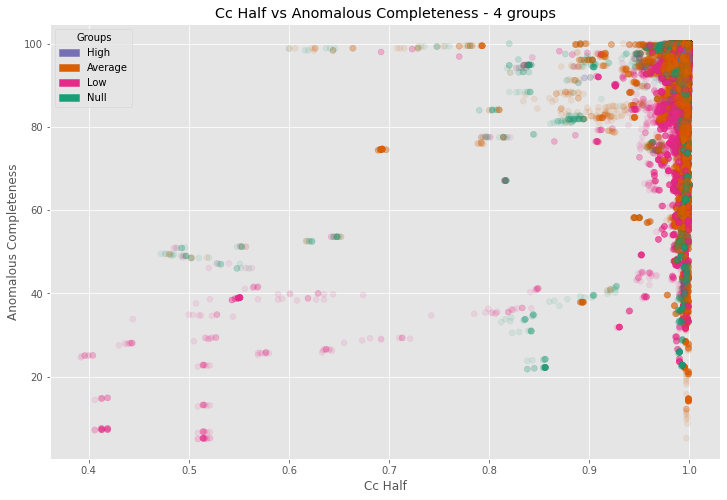

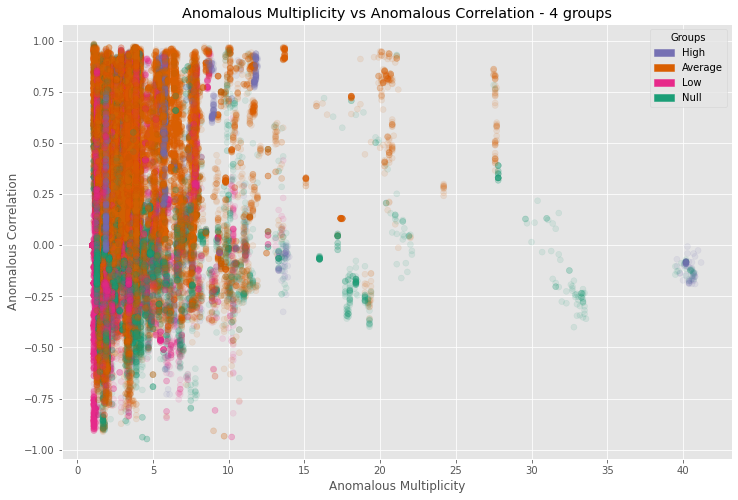

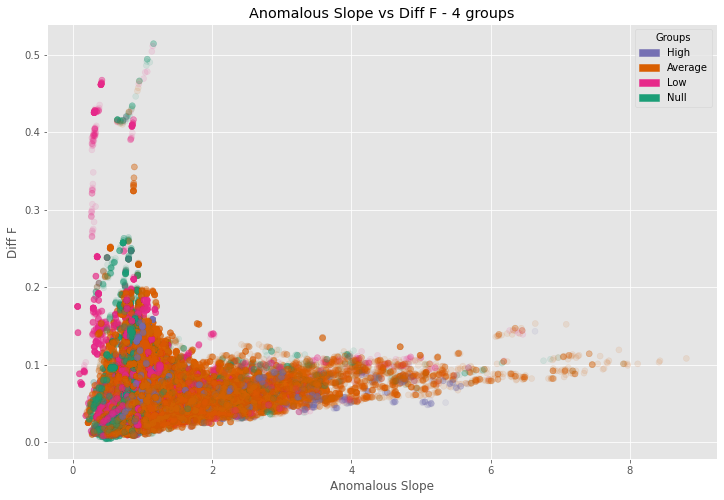

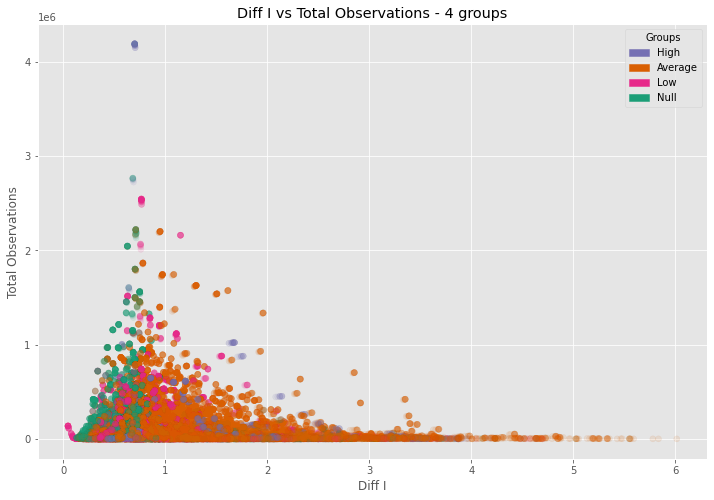

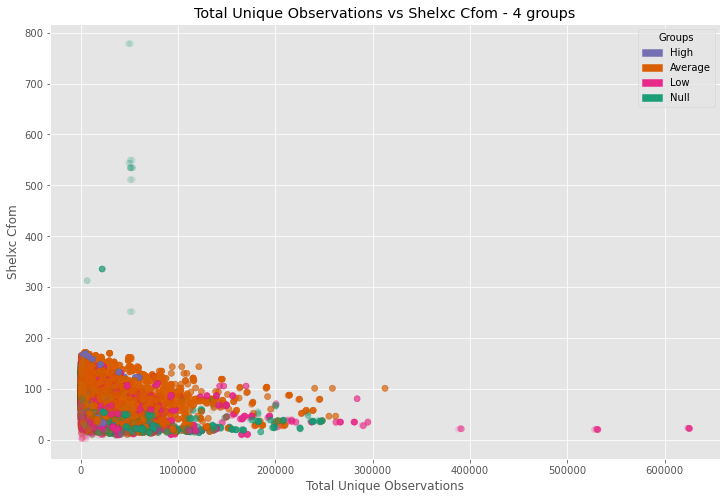

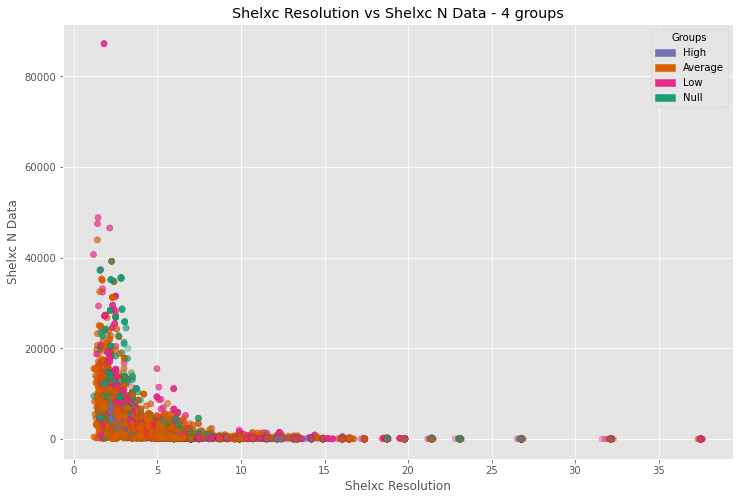

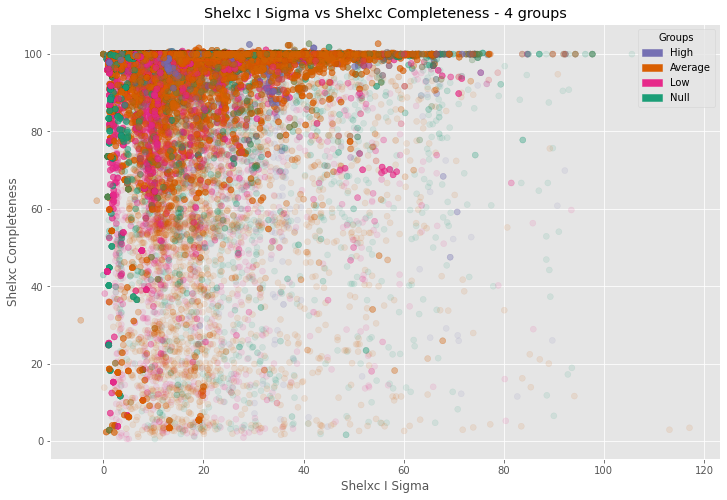

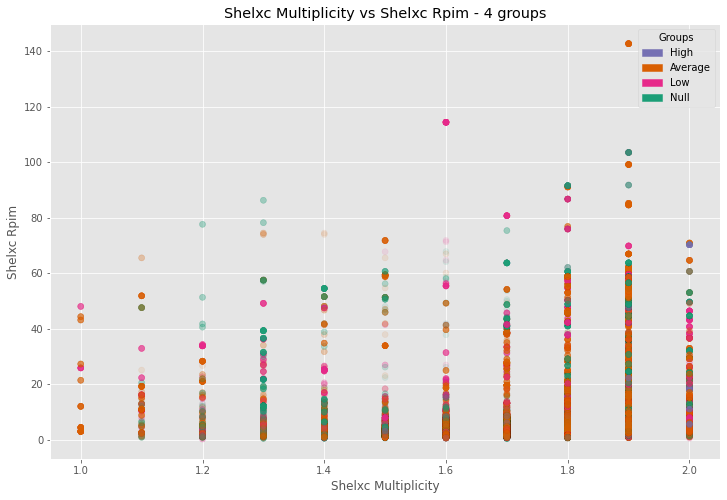

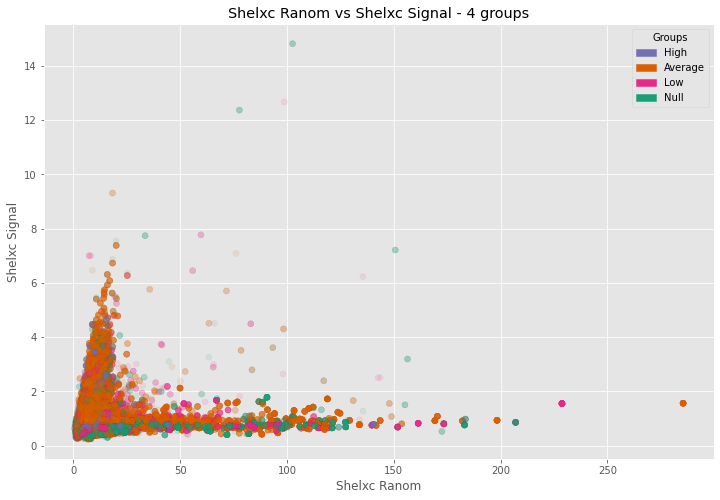

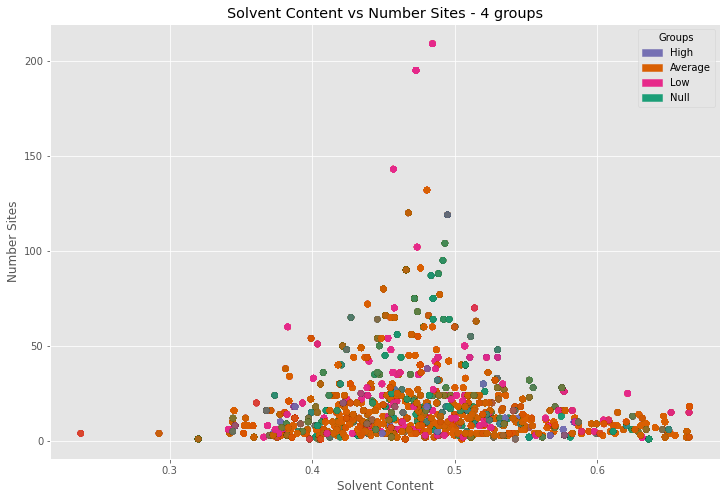

In [5]:
n_clusters = 4
_, (pred, c_bar) = avg_success_bar_plot(4, sort_legend=False)
c = spc_grp.map(c_bar)

# plot
def scatter_color(x_plot, y_plot):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(x_plot, y_plot, c=c, alpha=.1)

    # legend
    grps = pd.DataFrame(c.drop_duplicates())
    grps.columns = ["Color"]
    grps["Level"] = ["High", "Average", "Low", "Null"]
    patches = [mpl.patches.Patch(color=c, label=l) for c, l in grps.values]
    ax.legend(handles=patches, title="Groups")

    # labels
    ax.set_xlabel(x_plot.name.replace("_", " ").lower().title())
    ax.set_ylabel(y_plot.name.replace("_", " ").lower().title())
    ax.set_title(f"{ax.get_xlabel()} vs {ax.get_ylabel()} - {n_clusters} groups")

    plt.show()
    
    return fig, ax

for col1, col2 in x.columns.values.reshape((-1, 2)):
    scatter_color(x[col1], x[col2])

Although most plots do not show a clear success rate separation, some broad insight can still be extracted. The following conditions favor **high success rate**:

    - Diff F < 0.2
    - Anomalous Slope >= 1
    - Diff I >= 0.8
    - SHELXC Signal >= 1
    - SHELXC CFOM > 75
   
These indicators are based on *high success rate spacegroups*, not pure high success rate sweeps.

# REMOVE DOMINATING SINGLE-VALUED FEATURES, might hide other important ones